In [6]:
import os
import glob
import numpy as np
import soundfile as sf
from essentia.standard import *
import matplotlib.pyplot as plt

from tqdm import tqdm
from essentia.standard import *
from scipy.signal import butter, lfilter
from scipy.interpolate import make_interp_spline, BSpline

eps = np.finfo(np.float64).eps

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
%config InlineBackend.figure_format = 'retina'

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [3]:
def normalized_mean_spectrum(audio_file, ratio_idxs, fs=16000, harmonic=False, f0="max"):
    
    # note: this function is still too slow, we need to optimize it more
    
    freq_data_mean_ln = np.zeros(shape=(len(ratio_idxs),))
    
    # we start by instantiating the audio loader
    try:
        loader = essentia.standard.MonoLoader(filename=audio_file, sampleRate=fs)
    except:
        return freq_data_mean_ln

    # and then we actually perform the loading
    audio = loader()
    
    # apply a lowpass filter to focus on speeech
    #lowpass = LowPass(cutoffFrequency=8000, sampleRate=fs)
    #audio = lowpass(audio)
    
    # Some configuration parameters
    N = 2048
    H = N//2
    fMax = 5000
    fMin = 50
    w = Windowing(type='blackmanharris92')
    ratio_density = len(ratio_idxs)
    
    spectrum = Spectrum()
    
    spectralPeaks = SpectralPeaks(magnitudeThreshold=-60,
                                  maxFrequency=fMax,
                                  maxPeaks=len(ratio_idxs),
                                  minFrequency=fMin,
                                  sampleRate=fs) 
    
    harmonicPeaks = HarmonicPeaks(maxHarmonics=20,
                                  tolerance=0.2)
    
    pitchYin = PitchYin(frameSize=N,
                        interpolate=True,
                        maxFrequency=fMax,
                        minFrequency=fMin,
                        sampleRate=fs,
                        tolerance=0.15)
       
    pool = essentia.Pool()

    for frame in FrameGenerator(audio, frameSize=N, hopSize=H, startFromZero=True):
            
        dBSpectrum = 20 * np.log10(spectrum(w(frame)) + eps)
        freqs, magsdB = spectralPeaks(dBSpectrum)
        
        if f0 == "yin":
            p, pConf = pitchYin(frame)
        else:
            if len(freqs) > 0:
                p = freqs[np.argmax(magsdB)]
                pConf = 1.0
            else:
                p = 0
                pConf = 0.0
        
        if harmonic:
            hFreqs, hMags = harmonicPeaks(freqs, magsdB, p)
            pool.add('hFreqs', hFreqs)
            pool.add('hMags',  hMags)

        pool.add('freqs',  freqs)
        pool.add('magsdB', magsdB)
        pool.add('magsLn', np.power(10, magsdB/20))
        pool.add('p',      p)
        pool.add('pConf',  pConf)
 
    
    if harmonic:
        vFreqs = pool['hFreqs']
        vMags  = pool['hMags']
    else:
        vFreqs = pool['freqs']
        vMags  = pool['magsLn']
    
    for freqs, mags, p, pConf in zip(vFreqs, vMags, pool['p'], pool['pConf']):
        # skip if no f0 found
        if pConf <= 0.0:
            continue
        
        # skip if no peaks are found
        if len(freqs) < 1 or len(mags) < 1:
            continue
        
        f0_freq = p
        
        for peak_freq, peak_mag in zip(freqs, mags):
            
            octave_freq = f0_freq
            current_ratio = peak_freq / octave_freq
            
            
            while current_ratio > 3.0:
                octave_freq *= 2
                current_ratio = peak_freq / octave_freq

            r1 = current_ratio

            while current_ratio > 2.0:
                octave_freq *= 2
                current_ratio = peak_freq / octave_freq

            r2 = current_ratio
        
            #ratio_idx = np.squeeze(np.argwhere(ratio_idxs == find_nearest(ratio_idxs, r1)))
            #freq_data_mean_ln[ratio_idx] += peak_mag
            
            ratio_idx = np.squeeze(np.argwhere(ratio_idxs == find_nearest(ratio_idxs, r2)))
            freq_data_mean_ln[ratio_idx] += peak_mag
    
    # normalize
    freq_data_mean_ln /= freq_data_mean_ln.shape[0]
    
    return freq_data_mean_ln


In [111]:
def plot_mean_spectrum(ratio_idx, freq_data_mean_db):
    
    common = [6/5, 5/4, 4/3, 7/5, 3/2, 8/5, 5/3, 9/5, 2/1]
    names = ["m3", "M3", "P4", "tt", "P5", " m6", "M6", "m7", "P*"]
    
    ylim_min = -50
    ylim_max = 3
    ylim_range  = ylim_max - ylim_min
    
    print(ylim_max, ylim_min, ylim_range)
    
    plt.plot(ratio_idx, freq_data_mean_db, c='r', zorder=2)
    for ratio, name in zip(common, names):
        idx = np.argwhere(ratio_idx == find_nearest(ratio_idx, ratio))
        x_val = ratio_idx[idx]
        ymin = (53 - np.abs(np.squeeze(freq_data_mean_db[idx]))) / ylim_range
        ymax = ymin + 0.1
        print(ymin, ymax)
        plt.axvline(x_val, ymin=ymin, ymax=ymax, c='k', zorder=2, linewidth=1.0)
        plt.text(x=x_val, y=ymax+0.1)
    #plt.xticks(common, rotation=70)
    plt.xlim([0.9, 2.1])
    plt.ylim([-50,3])
    plt.ylabel('Mean amplitude (dB)')
    plt.xlabel('f0 ratio')
    plt.grid(axis='y')
    plt.show()
    #plot_path = os.path.join('plots', os.path.basename(audio_file).replace('flac', 'png'))
    #plt.savefig(plot_path, dpi=300, bbox_inches='tight')

In [112]:
def analyze_dataset(audio_files, f0="max"):
    
    if len(audio_files) < 1:
        print("No audio files...")
        return
    
    ratio_density = 250
    ratio_start = 0.0
    ratio_stop  = 2.2
    ratio_idxs = np.linspace(ratio_start, ratio_stop, ratio_density)
    
    freq_data_mean_ln = np.zeros(ratio_density)
    
    for audio_file in tqdm(audio_files):
        freq_data_mean_ln += normalized_mean_spectrum(audio_file, ratio_idxs, f0=f0)
        
    freq_data_mean_ln /= len(audio_files)
    freq_data_mean_db = 20 * np.log10((freq_data_mean_ln + eps)/np.max(freq_data_mean_ln + eps))
    
    
    # interpolate for smooth curve
    # note: this isn't the smartest way to achieve this
    # we should really try to do some kind of interpolation when
    # we are sorting the frequency bins into the ratios
    
    #xnew = np.linspace(ratio_idxs.min(),ratio_idxs.max(), 10000) 
    #spl = make_interp_spline(ratio_idxs, freq_data_mean_db, k=3)
    #freq_data_mean_db_smooth = spl(xnew)
    
    #plot_mean_spectrum(xnew, freq_data_mean_db_smooth)
    plot_mean_spectrum(ratio_idxs, freq_data_mean_db)

100%|██████████| 10/10 [00:01<00:00,  7.69it/s]


3 -50 53
0.595158843280312 0.695158843280312
0.5924835337323894 0.6924835337323894
0.5791458865347534 0.6791458865347534
0.5450832065950839 0.6450832065950839
0.6065222197607807 0.7065222197607807
0.48926188681082483 0.5892618868108248
0.48470053773883726 0.5847005377388372
0.4564274636782755 0.5564274636782756
0.5216423658754549 0.6216423658754548


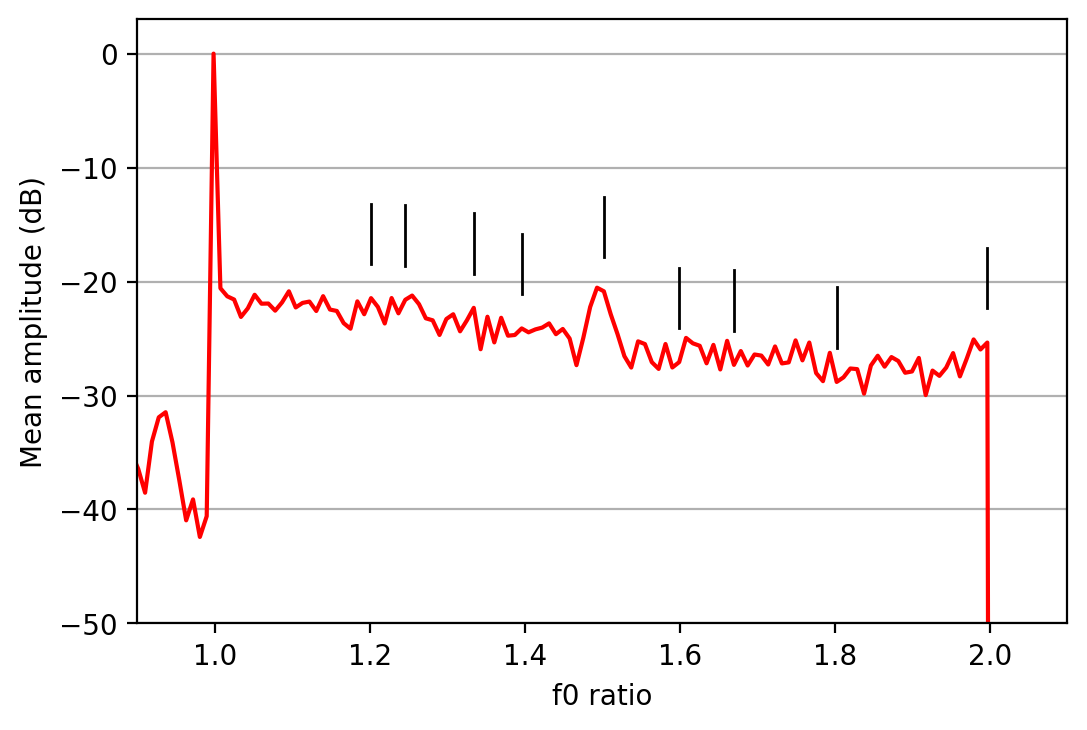

In [113]:
common_es = glob.glob('/Volumes/SteinmetzAlpha/Datasets/Speech/es/clips/*.mp3')[:10]
analyze_dataset(common_es, f0="max")

100%|██████████| 100/100 [00:38<00:00,  2.63it/s]


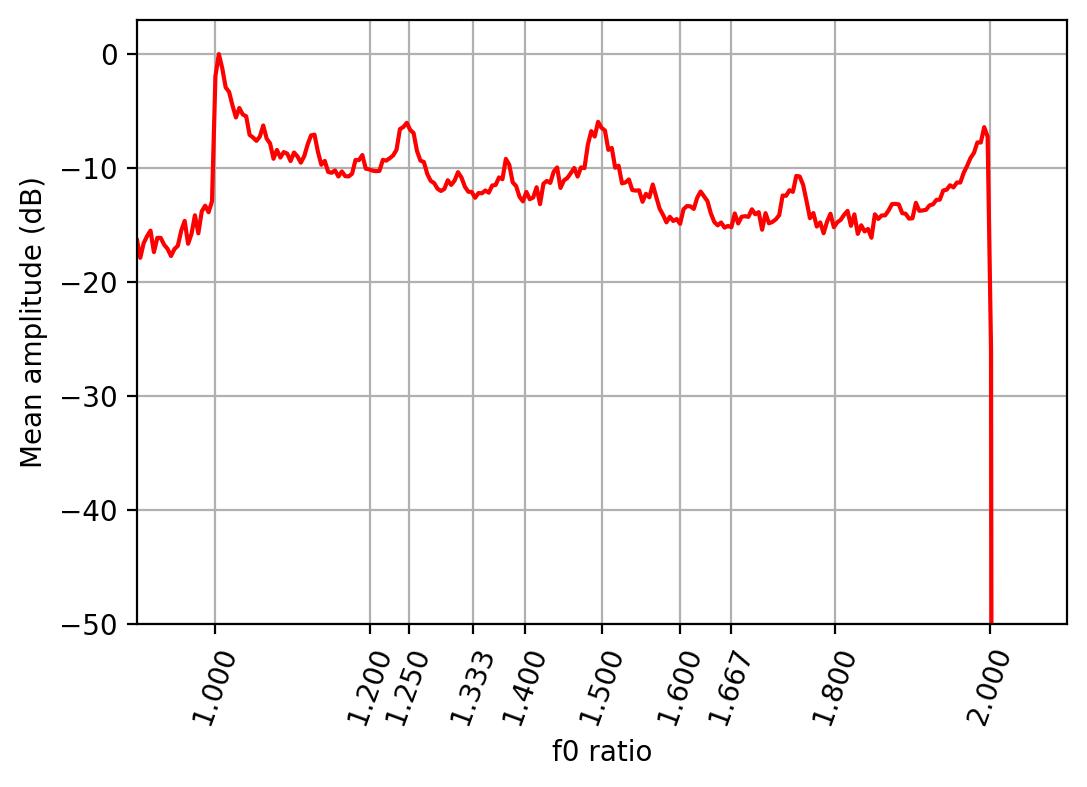

In [28]:
analyze_dataset(common_es, f0="yin")

## Questions and improvements

- How should f0 estimation be handled (max vs yin vs ?)
- In what way should we fold higher harmonics into the range of 1.0 to 2.0?
- Should the range of ratios extend more (ex: 0.9 - 2.1)?
- How do we statistically compare two specta?